<img src="./unal.png" align=left width="150" height="150"></img>



$\,$
---

<h2 align="center"> ANÁLISIS SOBRE ARRESTOS EN EEUU</h2>
<h3 align="center">Métodos ensamble de regresión. Random Forest</h3>


$\;$

---

## Random forests

Supóngase que se cuenta con un set de datos cuenta con un predictor muy importante o influyente que destaca sobre el resto. En este caso, todos o casi todos los árboles generados por bagging usarán este predictor en la primera ramificación, por lo que acabarán siendo similares unos a otros, y las predicciones entre ellos estarán altamente correlacionadas. En este escenario, la aplicación de bagging promediando valores correlacionados no consigue una reducción sustancial de la varianza con respecto a un solo árbol.

El método de random forests proporciona una mejora a los árboles combinados por bagging en cuanto a que los decorrelaciona, teniendo en cuenta solo un subgrupo de predictores en cada división. Al igual que en el bagging, se construyen un número de árboles de decisión a partir de pseudo-muestras generadas por bootstrapping. Esta vez, se escogen de entre todos los p predictores una muestra aleatoria de m predictores como candidatos antes de cada división, generalmente $m \approx \sqrt{p} \;\;$ (si $m=p$, bagging y random forests darían resultados equivalentes). Solo se aplica la división a uno de los m predictores. Esto hace que, de media, $(p–m)/p$ divisiones no tengan en cuenta el predictor más influyente, dando más oportunidades al resto.


Usar un número pequeño de m para aplicar random forests puede resultar útil cuando contamos con un gran número de predictores correlacionados.

Al igual que con bagging, aumentar el número de pseudo-árboles no incrementará el riesgo de overfitting, por lo que en la práctica usamos un valor lo suficientemente alto para conseguir una estabilización del test error.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree, preprocessing, model_selection, ensemble
from sklearn.tree import export_graphviz 
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, mean_squared_error, make_scorer, plot_confusion_matrix, classification_report
from sklearn import metrics

In [2]:
datos_hitters = pd.read_csv('Hitters.csv')

print('Filas:', datos_hitters.shape[0], 'Variables:', datos_hitters.shape[1])
print(type(datos_hitters))
print(datos_hitters.head())

Filas: 322 Variables: 20
<class 'pandas.core.frame.DataFrame'>
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
0    29      14      A        E      446       33      20     NaN         A  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      33      N        E      805       40       4    91.5 

In [3]:
datos_hitters.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,263.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,535.925882
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,451.118681
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,190.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,425.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000


In [4]:
# Datos faltantes (NaN) por variable
print(datos_hitters.isna().sum(axis = 0))

# Eliminamos los 59 registros con datos faltantes en "Salary"
datos_hitters = datos_hitters.dropna()
print('Tras eliminar NaNs\n','Filas:', datos_hitters.shape[0], 'Variables:', datos_hitters.shape[1])

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64
Tras eliminar NaNs
 Filas: 263 Variables: 20


In [5]:
print(datos_hitters.isna().sum(axis = 0))

AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64


Ya no se tienen datos faltantes.

#### Distribución de la variable respuesta "Salary"

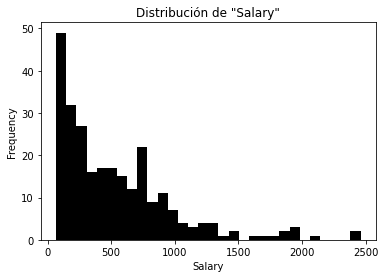

In [6]:
datos_hitters['Salary'].plot(kind='hist', bins=30, color='black')
plt.title('Distribución de "Salary"')
plt.xlabel('Salary')
plt.show()

In [7]:
# Aplicamos la transformación logarítmica a los datos de "Salary" para hacer su distribución mas normal
datos_hitters['Salary'] = np.log(datos_hitters['Salary'])

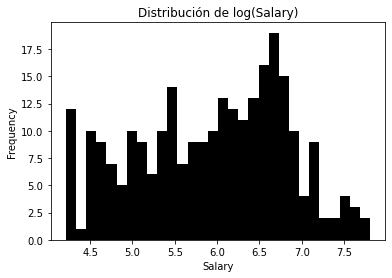

In [8]:
# Distribucion de la variable "Salary" transformada
datos_hitters['Salary'].plot(kind='hist', bins=30, color='black')
plt.title('Distribución de log(Salary)')
plt.xlabel('Salary')
plt.show()

In [9]:
# DIVISION MANUAL

X_train = datos_hitters.loc[:201, datos_hitters.columns != 'Salary']
y_train = datos_hitters.loc[:201, 'Salary']

X_test = datos_hitters.loc[201:, datos_hitters.columns != 'Salary']
y_test = datos_hitters.loc[201:, 'Salary']

In [10]:
# DIVISION ALEATORIA

# Separamos los predictores (X) de la variable respuesta (y)
#X = datos_hitters.loc[:, datos_hitters.columns != 'Salary']
#y = datos_hitters['Salary']

# Dividimos los datos en entrenamiento (80%) y test (20%) de forma aleatoria
#X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=0, test_size=0.2)

In [11]:
# Es necesario codificar las variables categorifcas "League", "NewLeague" y "Division" a numericas
cat = preprocessing.LabelEncoder()
for col in ['League', 'NewLeague', 'Division']:
    X_train.loc[:,col] = cat.fit_transform(X_train.loc[:,col])
    X_test.loc[:,col] = cat.fit_transform(X_test.loc[:,col])

### Importando clase RandomForestRegressor de la libreria sklearn.ensemble

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
# Establecemos un grid con las combinaciones de valores que queremos evaluar. 
grid_hiperparametros = {#'n_estimators': [500], #nº de arboles 
                        'max_features': list(range(2,19))} #nº de variables a tener en cuenta para las divisiones (mtry en R)

# Definimos las métricas de interés
metricas = {'r2':make_scorer(metrics.r2_score), 'mse': make_scorer(mean_squared_error)}

# Definimos los parámetros de búsqueda por validación cruzada
busqueda_grid = GridSearchCV(estimator = RandomForestRegressor(criterion='mse', random_state=0), #tipo de modelo
                             param_grid = grid_hiperparametros, 
                             cv = 10, #folds
                             #return_train_score = True,
                             scoring = metricas,
                             refit = 'mse',
                             n_jobs = -1) 

# Aplicamos la busqueda
busqueda_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18]},
             refit='mse',
             scoring={'mse': make_scorer(mean_squared_error),
                      'r2': make_scorer(r2_score)})

In [14]:
# Valores que devuelve la busqueda grid
busqueda_grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'params', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'split5_test_r2', 'split6_test_r2', 'split7_test_r2', 'split8_test_r2', 'split9_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2', 'split0_test_mse', 'split1_test_mse', 'split2_test_mse', 'split3_test_mse', 'split4_test_mse', 'split5_test_mse', 'split6_test_mse', 'split7_test_mse', 'split8_test_mse', 'split9_test_mse', 'mean_test_mse', 'std_test_mse', 'rank_test_mse'])

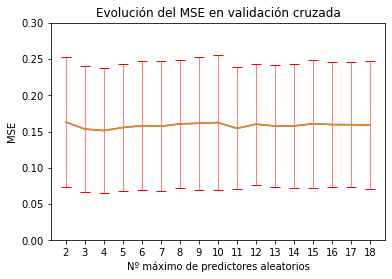

Valor del hiperparámetro óptimo:
 {'max_features': 2} 
MSE +- std = 0.163 +- 0.09 
R^2 = 0.805 +- 0.086


In [15]:
# Almacenamos en variables los resultados de la busqueda grid
n_variables_cv = busqueda_grid.cv_results_['param_max_features'].tolist()
mse_medio_cv = busqueda_grid.cv_results_['mean_test_mse'].tolist()
mse_std_cv = busqueda_grid.cv_results_['std_test_mse'].tolist()

# Grafico evolucion del MSE en validacion cruzada
plt.figure()
plt.plot(n_variables_cv, mse_medio_cv)
plt.errorbar(n_variables_cv, 
             mse_medio_cv, 
             yerr=mse_std_cv,
             ecolor = 'red', 
             elinewidth = 0.5, 
             capsize = 5,)
plt.title("Evolución del MSE en validación cruzada")
plt.xlabel('Nº máximo de predictores aleatorios')
plt.ylabel('MSE')
plt.ylim((0, 0.3))
plt.xticks(n_variables_cv)
plt.show()

# Mejores hiperparametros sobre los datos hold-out y métricas de validación cruzada
print('Valor del hiperparámetro óptimo:\n', busqueda_grid.best_params_,
     '\nMSE +- std =', round(busqueda_grid.cv_results_['mean_test_mse'][busqueda_grid.best_index_],3),
     '+-', round(busqueda_grid.cv_results_['std_test_mse'][busqueda_grid.best_index_],3),
     '\nR^2 =', round(busqueda_grid.cv_results_['mean_test_r2'][busqueda_grid.best_index_],3),
     '+-', round(busqueda_grid.cv_results_['std_test_r2'][busqueda_grid.best_index_],3))

In [16]:
# Ajustamos el modelo RF usando los hiperparametros optimos escogidos
modelo_rfR = RandomForestRegressor(criterion='mse', 
                                   #n_estimators = 500,
                                   max_features = 2, 
                                   oob_score = True, #uso de observaciones out-of-bag 
                                   random_state = 0, # semilla
                                   n_jobs = -1) # paralelizacion

# Entrenamos el modelo con los datos de entrenamiento 
modelo_rfR.fit(X_train, y_train)

RandomForestRegressor(max_features=2, n_jobs=-1, oob_score=True, random_state=0)

In [17]:
# Métrica OBB del ajuste
print('Métrica OOB =', round(modelo_rfR.oob_score_, 3))

Métrica OOB = 0.804


## Gráfica

In [25]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydot
import graphviz
# Pull out one tree from the forest
#tree = rf.estimators_[5]

In [26]:
tree_small = modelo_rfR.estimators_[5]
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = X_train.columns.tolist(), rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');                         #Esta línea guarda png en la carpeta donde se guardael actual script

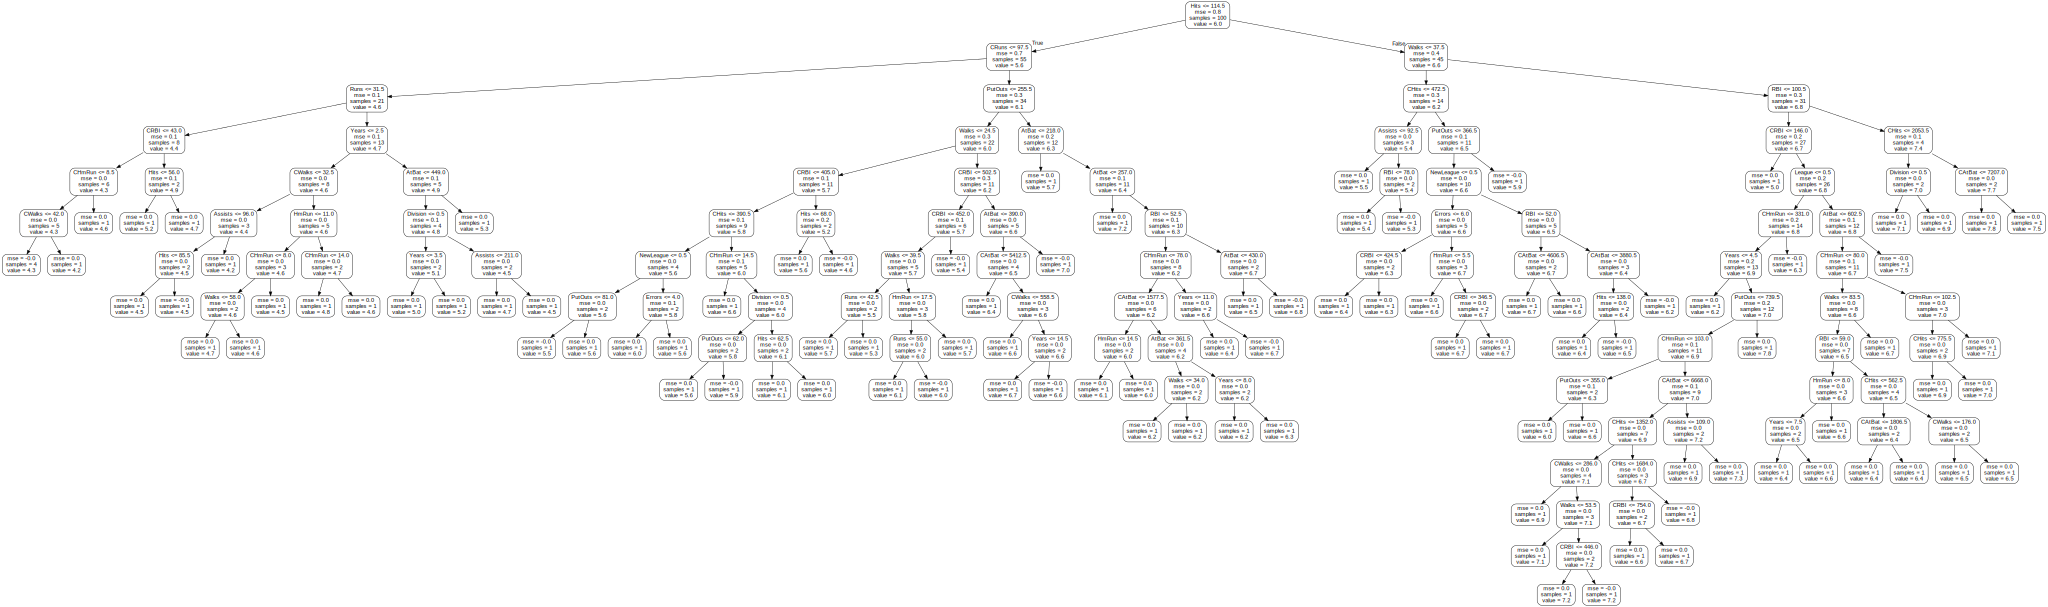

In [27]:
graphviz.Source(graph)

## Evaluación

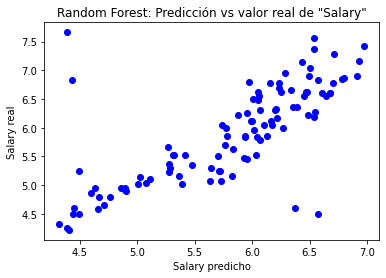

In [28]:
# Obtenemos las predicciones del modelo sobre los datos de test
y_pred = modelo_rfR.predict(X_test)

plt.scatter(y_pred, y_test, color = 'blue') 
plt.title('Random Forest: Predicción vs valor real de "Salary"')
plt.xlabel('Salary predicho')
plt.ylabel('Salary real')
plt.show()

In [29]:
# TEST

# Metricas en test
print('Métricas de test:',
      '\nMAE =', round(metrics.mean_absolute_error(y_test, y_pred),3),
      '\nMSE =', round(metrics.mean_squared_error(y_test, y_pred),3),
      '\nRMSE =', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3),
      '\nR^2 =', round(modelo_rfR.score(X_test, y_test),3))

Métricas de test: 
MAE = 0.336 
MSE = 0.341 
RMSE = 0.584 
R^2 = 0.522


In [30]:
print(modelo_rfR.score(X_train, y_train))
print(modelo_rfR.score(X_test, y_test))

0.9739226375604453
0.5223116499895292


#### Importancia variables
La importancia de cada variable calculada hace referencia a la disminución media de pureza que proporciona:

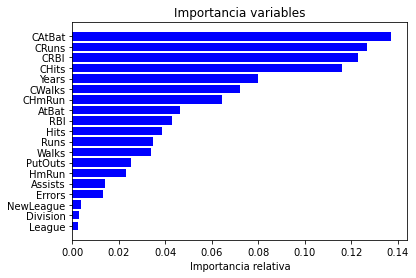

In [31]:
# Recuperamos los valores de importancia del modelo ajustado
importancias = modelo_rfR.feature_importances_

# Ordenamos los valores de importancia en orden descendiente
indices = np.argsort(importancias)

X = datos_hitters.loc[:, datos_hitters.columns != 'Salary']
plt.title('Importancia variables')
plt.barh(range(len(indices)), importancias[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Importancia relativa')
plt.show()